In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import jaccard_score, confusion_matrix, classification_report, f1_score, accuracy_score

In [2]:
train = pd.read_csv('train_new.csv', index_col=0)
test = pd.read_csv('test_new.csv', index_col=0)

In [3]:
train.head()

,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,STATE_ID,EMPLOYEE_CODE_ID,AADHAR_FLAG,PAN_FLAG,...,PRIMARY_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT,AGE,Salaried,Self employed
0,50578,58400,89.55,67,22807,45,6,1998,1,0,...,0,0,0,0,0,0,0,39,1,0
1,47145,65550,73.23,67,22807,45,6,1998,1,0,...,1991,0,1,23,23,0,1,37,0,1
2,53278,61360,89.63,67,22807,45,6,1998,1,0,...,0,0,0,0,0,0,0,37,0,1
3,57513,66113,88.48,67,22807,45,6,1998,1,0,...,31,0,0,8,15,1,1,28,0,1
4,52378,60300,88.39,67,22807,45,6,1998,1,0,...,0,0,0,0,0,1,1,45,0,1


# Preprocessing and normalizing the data

In [4]:
X = train.drop(['LOAN_DEFAULT'], axis=1).values
y = train['LOAN_DEFAULT'].values

In [5]:
X.shape

(233154, 32)

In [6]:
y.shape

(233154,)

In [7]:
X[:1]

array([[5.0578e+04, 5.8400e+04, 8.9550e+01, 6.7000e+01, 2.2807e+04,
        4.5000e+01, 6.0000e+00, 1.9980e+03, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9000e+01,
        1.0000e+00, 0.0000e+00]])

In [8]:
X = StandardScaler().fit(X).transform(X.astype('float'))
X[:1]

array([[-0.29133529, -0.92189534,  1.2921334 , -0.08500189,  0.90733606,
        -1.0852164 , -0.28161112,  0.45990118,  0.43591589, -0.28592912,
        -0.41171888, -0.15425693, -0.04617234, -0.85545269, -0.46780372,
        -0.53561706, -0.28526422, -0.17606398, -0.0920098 , -0.09171146,
        -0.03188381, -0.03983456, -0.03932261, -0.08658051, -0.3997818 ,
        -0.25356649, -0.59019844, -0.56863979, -0.29244957,  0.05872976,
         1.17582939, -1.0998148 ]])

Although the original data was split to train and test sets, I discovered that the test data had not been labeled, which makes it difficult to measure the accuracy of the models.

To resolve, this I will split the train dataset with 0.3 test size so that I can measure the accuracy, and the dataset called 'test' will be used for the actual prediction

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(163207, 32) (69947, 32) (163207,) (69947,)


# K-nearest neighbor model


___
First, I will find the best value for k

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
Ks = range(1,10);
scores = []
for k in Ks:
    knn  = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))

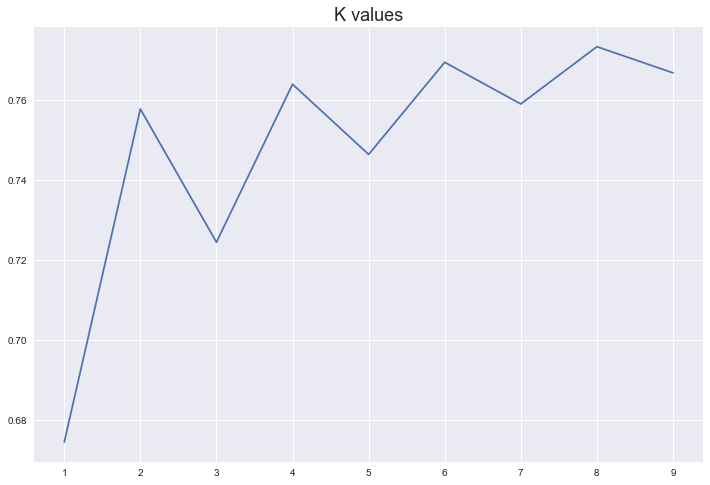

In [14]:
plt.figure(figsize=(12,8))
plt.plot(Ks, scores)
plt.title('K values', size=18)
plt.show()

Based on the chart the k value with the accuracy on this dataset is 8.

I will now run the model with this k value and save the predictions

In [15]:
knn  = KNeighborsClassifier(n_neighbors=8).fit(X_train,y_train)
KNNpred = knn.predict(X_test)
KNNpred

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
jaccard_KNN = jaccard_score(y_test, KNNpred, average='weighted')
f1_KNN = f1_score(y_test, KNNpred, average='weighted')
accuracy_KNN = accuracy_score(y_test, KNNpred)
print(jaccard_KNN, f1_KNN, accuracy_KNN)

0.6133861026739086 0.7008000823331711 0.7733712668163037


___

# Support Vector Machine 


I first try the Radial Basis Function kernel and see its accuracy

In [14]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(kernel='rbf').fit(X_train, y_train)

In [13]:
SVMpred = svm.predict(X_test)
SVMpred

array([0, 0, 0, 0, 0], dtype=int64)